In [1]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [2]:
trainloader = DataLoader(Dataset2p0(dir='w3_ss/train',labels='w3_ss/y_train.pt'),batch_size=32,shuffle=True)
devloader = DataLoader(Dataset2p0(dir='w3_ss/dev',labels='w3_ss/y_dev.pt'),batch_size=32,shuffle=True)

In [26]:
class Andrew(nn.Module):
    def __init__(self,device,windowsize) -> None:
        super().__init__()
        self.device = device
        self.windowsize = windowsize
        self.encoder = Frodo(n_features=5000,device=device).to(device)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,self.windowsize,1,5000)
        x = torch.Tensor().to(self.device)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
model = Andrew(device=DEVICE,windowsize=9).to(DEVICE)

In [27]:
X,y = next(iter(devloader))
X,y = X.to(DEVICE),y.to(DEVICE)
X = X.view(-1,3,1,5000)
x = torch.Tensor().to(DEVICE)
for t in range(X.size(1)):
    xi = model.encoder(X[:,t,:,:],classification=False)
    x = torch.cat([x,xi.unsqueeze(0)],dim=0)
o,_ = model.lstm(x)
o[-1].shape

torch.Size([32, 64])

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  3794


In [ ]:
optimization_loop(model,trainloader,devloader,criterion,optimizer,epochs=20,DEVICE=DEVICE)

{'precision': 0.7931234077490329, 'recall': 0.7551367282604621, 'f1': 0.77109506715147}
0.30996531358471624


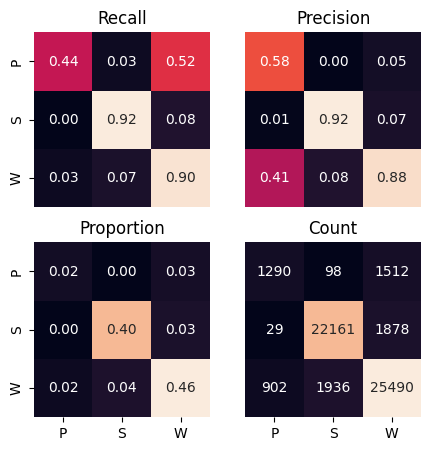

In [9]:
loss,metrics,y_true,y_pred,logits = evaluate(devloader,model,criterion,DEVICE)
cm_grid(y_true=y_true,y_pred=y_pred)
print(metrics) 
print(loss)

In [ ]:
with torch.no_grad():
    y_true = torch.Tensor()
    y_pred = torch.Tensor()
    y_logits = torch.Tensor()
    loss_total = 0
    for (Xi,yi) in devloader:
        y_true = torch.cat([y_true,yi.argmax(axis=1)])

        Xi,yi = Xi.to(DEVICE),yi.to(DEVICE)
        logits = model(Xi,classification=False)
        # loss = criterion(logits,yi)
        # loss_total += loss.item()
        
        y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
        # y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu()])


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
# logits_tsne = tsne.fit_transform(X_dev)
logits_tsne = tsne.fit_transform(y_logits.detach().cpu())
df = pd.DataFrame(logits_tsne)
df['y'] = y_true
sns.scatterplot(data=df,x=0,y=1,hue='y')